In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [27]:
#list of all disorders from the ldsc analysis
disorders = ['ADHD','ANOREXIA', 'ANXIETY','ARTHRITIS','ASD','AUD','BILIARYCHIRROSIS','BPD','CHRONICPAIN','CUD','ENDOMETRIOSIS','EPILEPSY','FATIGUE','FIBROMYALGIA','GDM','GOUT','HOARDING','IBD','IBS','LUPUS','MDD','MIGRAINE','MS','MYASTHENIA','OCD','OD','PANIC','PARKINSONS','PCOS','PREECLAMPSIA','PRETERMBIRTH','PTSD','SJOGRENS','SZC','THYROID','TS']

In [28]:
len(disorders)

36

In [29]:
#make list of files to read in
ex_table_files = glob.glob('*_extracted_table.txt')
# Sort the list of files based on the numeric part in the filenames
ex_table_files = sorted(ex_table_files, key=lambda x: int(x.split('_')[0]), reverse=True)

In [30]:
len(ex_table_files)

35

In [31]:

df_list = []

#read in files to dataframes 
for file in ex_table_files:
    df = pd.read_csv(file, delim_whitespace=True
                     , skiprows=1) 
    #select relevant columns
    df = df[['p1','p2','rg','se','z','p']]
    #remove last two rows
    df = df.iloc[:-2]
    df_list.append(df)

In [32]:
len(df_list)

35

In [34]:
def make_correlation_matrix2(column, df_list):
    n = len(df_list) +1
    array = np.zeros((n, n))

    for i, df in enumerate(df_list):
        val = df[column].values

        if len(val) > 0:  # Check if 'rg' column is not empty
            # Extract values of 'rg' column to a list
            rg_values = list(val)

            # Fill the matrix starting from below the diagonal
            for j in range(i + 1, n):
                array[j, i] = rg_values.pop(0)

    # Fill the diagonal 
    if column == 'rg':            
        np.fill_diagonal(array, 1)
    else:
        np.fill_diagonal(array, 0.00005)

    # Convert the filled cells to numeric
    array = array.astype(float)
    

    # Create a DataFrame with disorders as column and index names
    return pd.DataFrame(array, index=disorders, columns=disorders), array


In [35]:
#corr_pval_df = make_correlation_matrix('p', df_list)
gen_corr_df, corr_matrix = make_correlation_matrix2('rg', df_list)

In [36]:
gen_corr_df.describe()

,ADHD,ANOREXIA,ANXIETY,ARTHRITIS,ASD,AUD,BILIARYCHIRROSIS,BPD,CHRONICPAIN,CUD,...,PANIC,PARKINSONS,PCOS,PREECLAMPSIA,PRETERMBIRTH,PTSD,SJOGRENS,SZC,THYROID,TS
count,36.000000,35.000000,34.000000,36.000000,36.000000,33.000000,34.000000,36.000000,35.000000,36.000000,...,34.000000,34.000000,33.000000,33.000000,34.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.284567,0.006093,0.140945,-0.006025,0.209556,0.095250,0.009479,0.058556,0.191369,0.136511,...,-0.002048,0.084911,-0.086121,0.003627,0.112438,0.037094,0.057372,0.030725,0.031222,0.027778
std,0.395961,0.376202,0.605942,0.590676,0.735170,0.230421,0.280488,0.291027,0.292005,0.369871,...,0.383934,0.226647,0.872649,0.219596,0.340436,0.180694,0.220467,0.167624,0.167356,0.166667
min,-0.141500,-0.563500,-2.873000,-3.158700,-0.334800,-0.116800,-1.135000,-0.752000,-0.114500,-0.488300,...,-1.917000,0.000000,-4.055000,-0.703900,0.000000,-0.170200,-0.081600,-0.023700,0.000000,0.000000
25%,0.073175,-0.129100,0.000718,-0.036150,0.000000,-0.010600,-0.009907,-0.012725,0.000000,-0.001050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.180400,-0.039800,0.186950,0.005950,0.067050,0.013500,0.008908,0.007700,0.115500,0.009400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.350700,0.034010,0.352875,0.101525,0.187850,0.113800,0.093747,0.112750,0.270250,0.120700,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.922700,1.683000,1.000000,1.000000,4.290200,1.000000,1.000000,1.000000,1.237000,1.627100,...,1.000000,1.000000,2.255000,1.000000,1.536000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
gen_corr_df.fillna(0, inplace=True)

In [38]:
full_matrix = np.tril(corr_matrix) + np.tril(corr_matrix, -1).T
full_df = pd.DataFrame(full_matrix, index=disorders, columns=disorders)

In [ ]:
""" full_df.to_csv('genetic_correlation.csv', header=True, index=True)
gen_corr_df.to_csv('genetic_correlation_all.csv', header= True, index=True) """

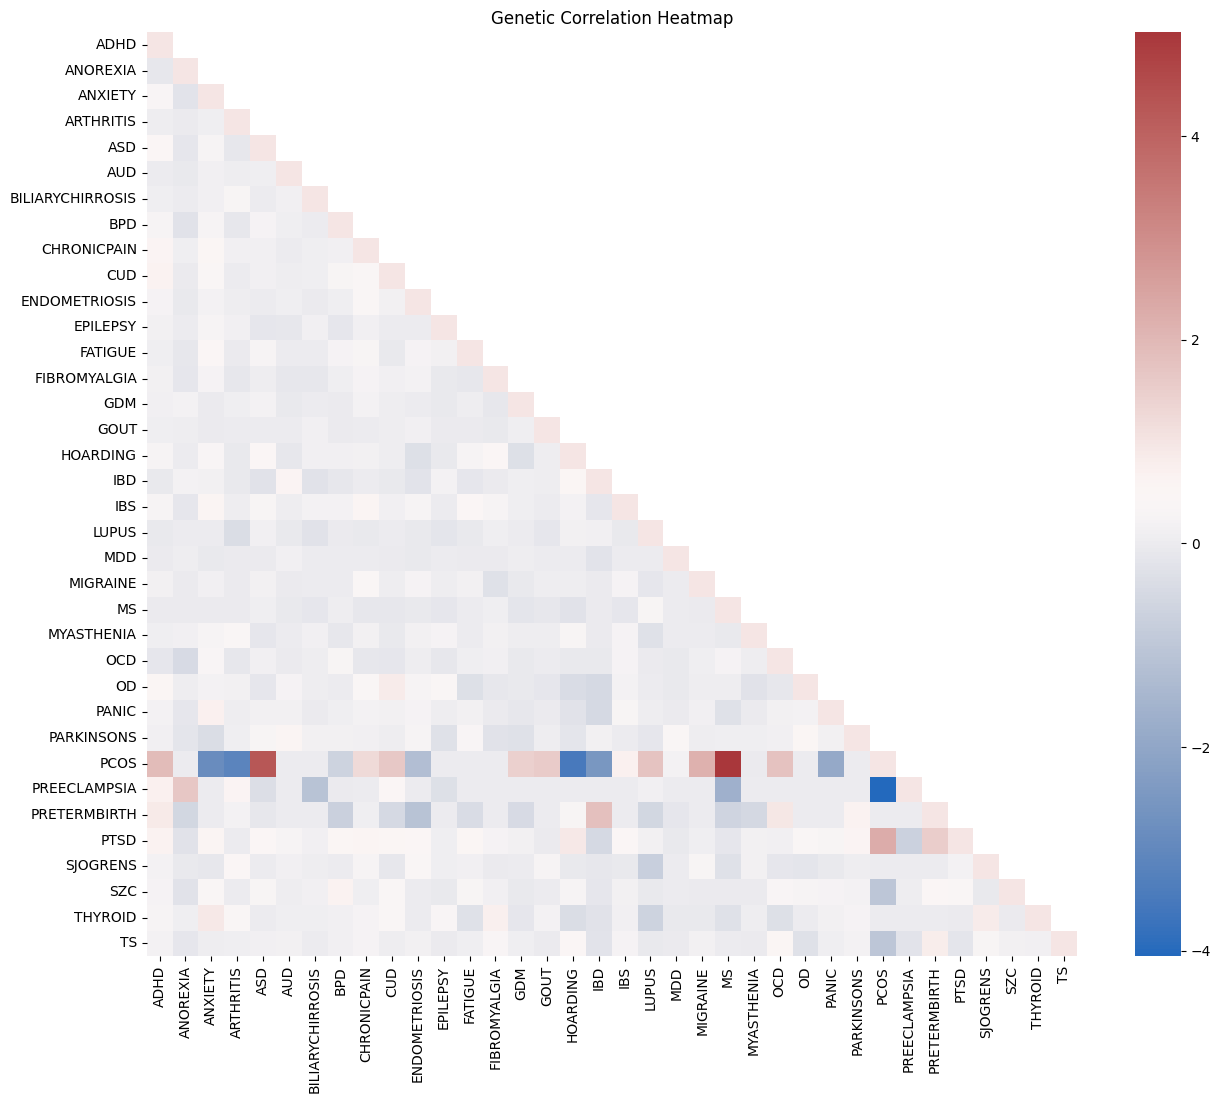

In [40]:
# Create a mask for the upper triangular part over the diagonal
mask = np.triu(np.ones_like(gen_corr_df), k=1)

# Plot the heatmap
plt.figure(figsize=(15,12))
heatmap= sns.heatmap(gen_corr_df, cmap='vlag',mask=mask)

plt.title('Genetic Correlation Heatmap')
plt.show()



<Figure size 2000x1500 with 0 Axes>

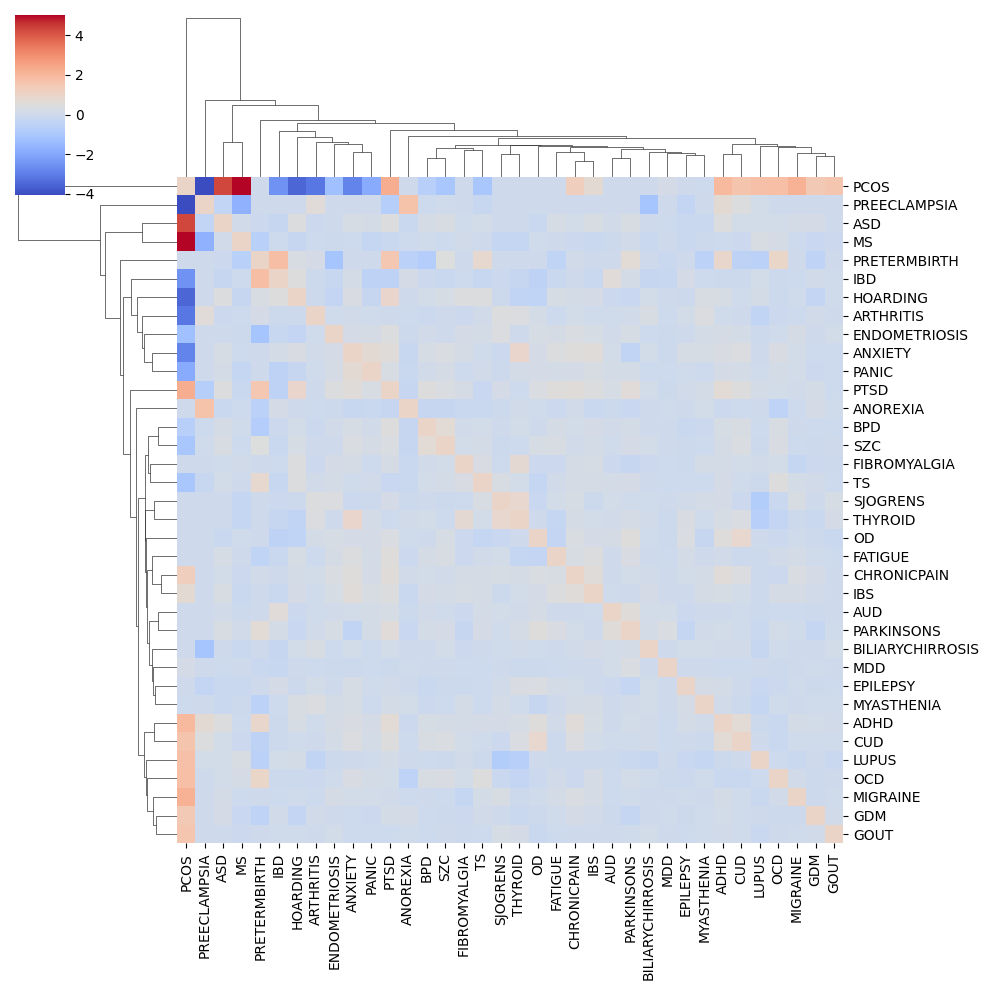

In [41]:
#plot clustermap
plt.figure(figsize=(20,15))
sns.clustermap(full_df,cmap='coolwarm')
plt.show()